<a href="https://colab.research.google.com/github/paulinaslo/Churn-Analysis/blob/main/Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analiza migracji klientów**

##### Głównym celem projektu jest stworzenie modelu, który będzie w stanie skutecznie przewidywać, czy dany klient opuści usługę. W tym celu porównam regresję logistyczną i drzewo decyzyjne, optymalizując parametry modelu dla uzyskania jak najlepszej skuteczności.


### **Opis danych**

Zestaw danych klientów obejmuje różnorodne informacje na temat ich aktywności i charakterystyk. Poniżej przedstawiam opis kluczowych kolumn:

*   customer_id: Unikalny identyfikator klienta
*   credit_score: Ocena kredytowa klienta
*   country: Kraj, w którym klient mieszka
*   gender: Płeć klienta
*   age: Wiek klienta
*   tenure: Okres korzystania z usług
*   balance: Saldo na koncie klienta
*   products_number: Liczba produktów posiadanych przez klienta
*   credit_card: Informacja, czy klient posiada kartę kredytową (1 - tak, 0 - nie)
*   active_member: Informacja, czy klient jest aktywnym członkiem (1 - tak, 0 - nie)
*   estimated_salary: Szacowana roczna pensja klienta
*   churn: Zmienna binarna określająca, czy klient odszedł (1 - tak, 0 - nie)


### **Inicjalizacja SparkSession**

In [8]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.1.2-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Churn Prediction").getOrCreate()


### **Załadowanie** **danych**

In [9]:
df_spark = spark.read.csv("Bank_Customer_Churn_Prediction.csv", header=True, inferSchema=True)

In [10]:
df_spark.show()

+-----------+------------+-------+------+---+------+---------+---------------+-----------+-------------+----------------+-----+
|customer_id|credit_score|country|gender|age|tenure|  balance|products_number|credit_card|active_member|estimated_salary|churn|
+-----------+------------+-------+------+---+------+---------+---------------+-----------+-------------+----------------+-----+
|   15634602|         619| France|Female| 42|     2|      0.0|              1|          1|            1|       101348.88|    1|
|   15647311|         608|  Spain|Female| 41|     1| 83807.86|              1|          0|            1|       112542.58|    0|
|   15619304|         502| France|Female| 42|     8| 159660.8|              3|          1|            0|       113931.57|    1|
|   15701354|         699| France|Female| 39|     1|      0.0|              2|          0|            0|        93826.63|    0|
|   15737888|         850|  Spain|Female| 43|     2|125510.82|              1|          1|            1|

### **Wczytanie** **bibliotek**

In [11]:
import io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import count, when, col
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


# **Analiza eksploracyjna**




### **Wyświetlenie informacje o danych**

In [12]:
df_spark.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- balance: double (nullable = true)
 |-- products_number: integer (nullable = true)
 |-- credit_card: integer (nullable = true)
 |-- active_member: integer (nullable = true)
 |-- estimated_salary: double (nullable = true)
 |-- churn: integer (nullable = true)



### **Statystyki opisowe dla kolumn numerycznych**

In [13]:
numeric_columns = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary']
df_numeric = df_spark.select(numeric_columns)

df_numeric.describe().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
|summary|     credit_score|               age|            tenure|          balance|   products_number| estimated_salary|
+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
|  count|            10000|             10000|             10000|            10000|             10000|            10000|
|   mean|         650.5288|           38.9218|            5.0128|76485.88928799961|            1.5302|100090.2398809998|
| stddev|96.65329873613035|10.487806451704587|2.8921743770496837|62397.40520238599|0.5816543579989917|57510.49281769821|
|    min|              350|                18|                 0|              0.0|                 1|            11.58|
|    max|              850|                92|                10|        250898.09|                 4|        199992.48|
+-------+-----------------+-----

### **Unikalne wartości w kolumnie 'country' oraz 'gender'**

In [14]:
unique_countries = df_spark.select('country').distinct().collect()
print("Unique countries:", [row['country'] for row in unique_countries])

unique_genders = df_spark.select('gender').distinct().collect()
print("Unique genders:", [row['gender'] for row in unique_genders])

# Ilość wystąpień każdej wartości w kolumnie 'country'
df_spark.groupBy('country').count().show()

# Ilość wystąpień każdej wartości w kolumnie 'gender'
df_spark.groupBy('gender').count().show()


Unique countries: ['Germany', 'France', 'Spain']
Unique genders: ['Female', 'Male']
+-------+-----+
|country|count|
+-------+-----+
|Germany| 2509|
| France| 5014|
|  Spain| 2477|
+-------+-----+

+------+-----+
|gender|count|
+------+-----+
|Female| 4543|
|  Male| 5457|
+------+-----+



### **Sprawdzenie brakujących danych**

In [15]:
df_spark.select([count(when(col(c).isNull(), c)).alias(c) for c in df_spark.columns]).show()

+-----------+------------+-------+------+---+------+-------+---------------+-----------+-------------+----------------+-----+
|customer_id|credit_score|country|gender|age|tenure|balance|products_number|credit_card|active_member|estimated_salary|churn|
+-----------+------------+-------+------+---+------+-------+---------------+-----------+-------------+----------------+-----+
|          0|           0|      0|     0|  0|     0|      0|              0|          0|            0|               0|    0|
+-----------+------------+-------+------+---+------+-------+---------------+-----------+-------------+----------------+-----+



### **Usunięcie kolumny 'customer_id'**

In [16]:
df_spark = df_spark.drop("customer_id")

### **Analiza rozkładów zmiennych numerycznych**

---



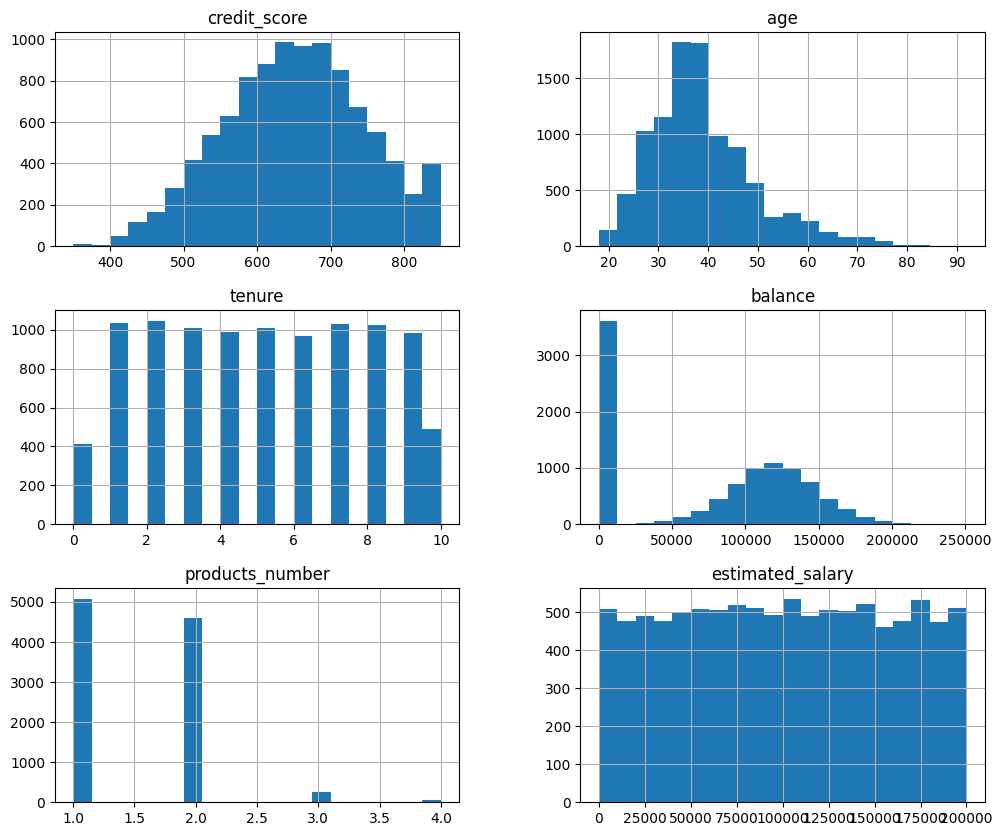

In [17]:
df_pd_numeric = df_spark.select(numeric_columns).toPandas()
df_pd_numeric.hist(figsize=(12, 10), bins=20)
plt.show()


### **Ilość wystąpień każdej wartości w kolumnie 'country'**

<ipython-input-18-f0475db25bce>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='country', y='count', data=country_counts, palette='pastel')


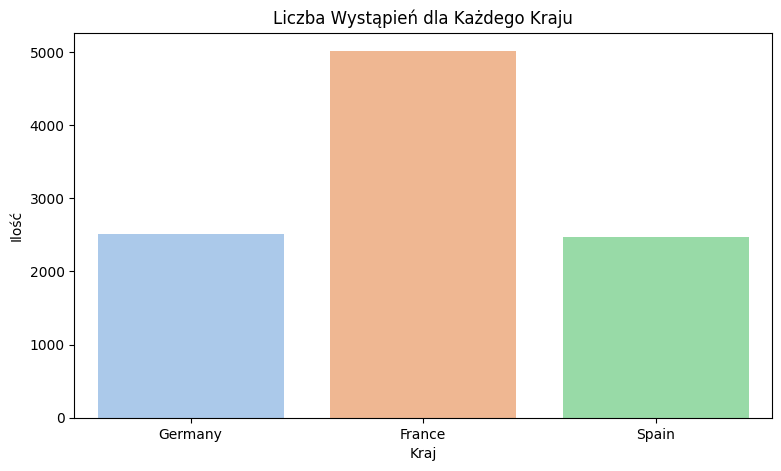

In [18]:
country_counts = df_spark.groupBy('country').count().toPandas()
plt.figure(figsize=(9, 5))
sns.barplot(x='country', y='count', data=country_counts, palette='pastel')
plt.title('Liczba Wystąpień dla Każdego Kraju')
plt.xlabel('Kraj')
plt.ylabel('Ilość')
plt.show()


Najwięcej klientów pochodzi z Francji, co stanowi najliczniejszy segment w danych. Niemcy zajmują drugie miejsce, a Hiszpania jest najmniej reprezentowana wśród trzech krajów.

### **Ilość wystąpień dla każdej wartości w kolumnie 'gender'**

<ipython-input-19-71a86f8dced1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y='count', data=gender_counts, palette='pastel')


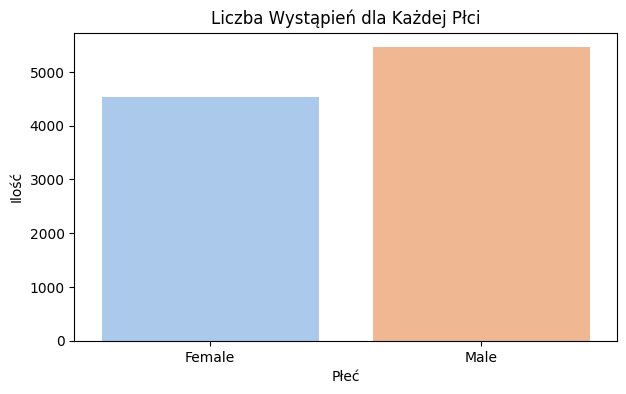

In [19]:
gender_counts = df_spark.groupBy('gender').count().toPandas()

plt.figure(figsize=(7, 4))
sns.barplot(x='gender', y='count', data=gender_counts, palette='pastel')
plt.title('Liczba Wystąpień dla Każdej Płci')
plt.xlabel('Płeć')
plt.ylabel('Ilość')
plt.show()


Analiza ilości wystąpień dla płci w ramach zbioru danych klientów banku ukazuje, że mężczyźni stanowią większą grupę, reprezentującą 5457 klientów, podczas gdy kobiety, z liczbą 4543, są nieco mniej liczne.

### **Macierz korelacji między zmiennymi numerycznymi**

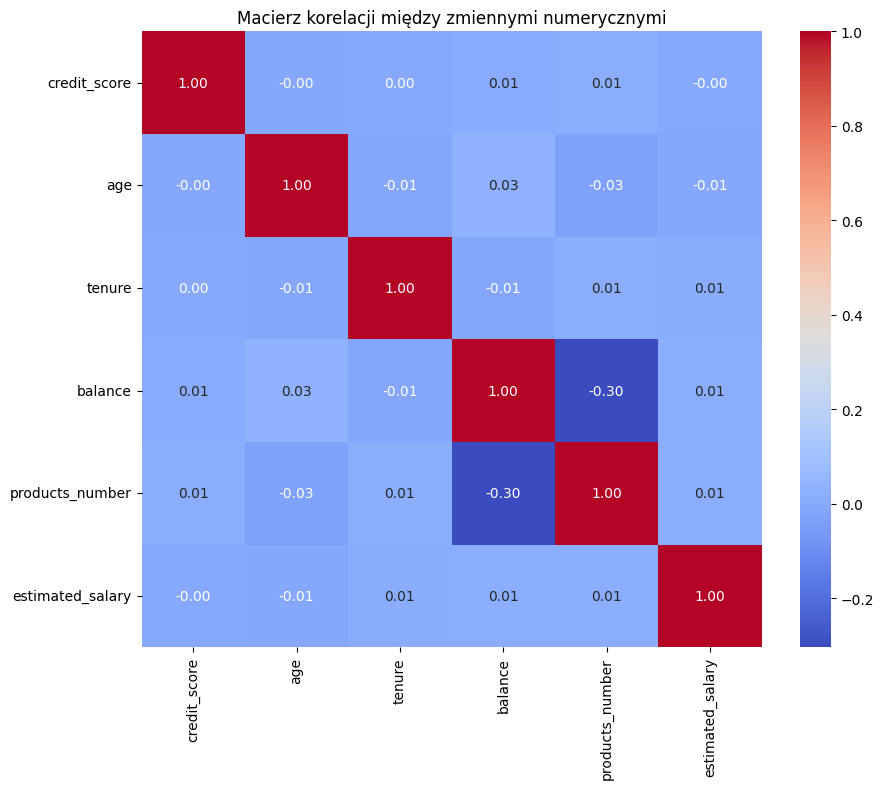

In [20]:
df_spark_numeric = df_spark.select(numeric_columns)

vector_assembler = VectorAssembler(inputCols=numeric_columns, outputCol='features')
df_spark_features = vector_assembler.transform(df_spark_numeric)

corr_matrix_spark = Correlation.corr(df_spark_features, 'features').collect()[0][0]

# Konwersja macierzy korelacji do Pandas DataFrame
corr_matrix_pd = pd.DataFrame(corr_matrix_spark.toArray(), columns=numeric_columns, index=numeric_columns)

# Wizualizacja macierzy korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_pd, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Macierz korelacji między zmiennymi numerycznymi')
plt.show()


Heatmapa macierzy korelacji dla zmiennych numerycznych ukazuje, że występuje umiarkowana ujemna korelacja między liczbą produktów a saldem na koncie (około -0.3), co sugeruje, że wzrost liczby produktów może być powiązany z umiarkowanym spadkiem salda, natomiast pozostałe korelacje są niskie.

### **Procentowy udział kolumny 'Churn'**

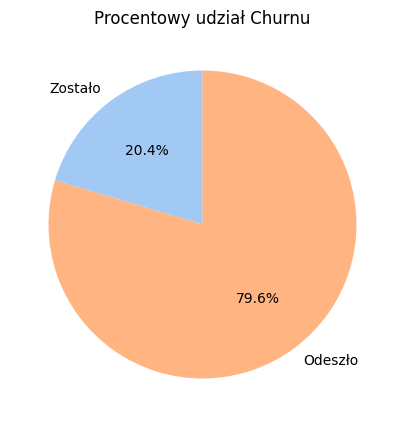

In [21]:
churn_counts = df_spark.groupBy('churn').count().toPandas()
labels = ['Zostało', 'Odeszło']
sizes = churn_counts['count']
colors = sns.color_palette('pastel')[0:2]  # Paleta pastelowa

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Procentowy udział Churnu')
plt.show()


Na przedstawionym wykresie kołowym można zauważyć, że:

79.6% klientów pozostało (nie opuściło banku),
20.4% klientów odeszło (opuściło bank).

Ta informacja może wskazywać na stosunkowo stabilną sytuację wśród klientów, gdzie większość z nich nadal korzysta z usług banku.

### **Tworzenie wykresu dla wieku w zależności od Churnu**

<ipython-input-22-3ad95ffa06ef>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y='age', data=df_spark.toPandas(), palette='pastel')


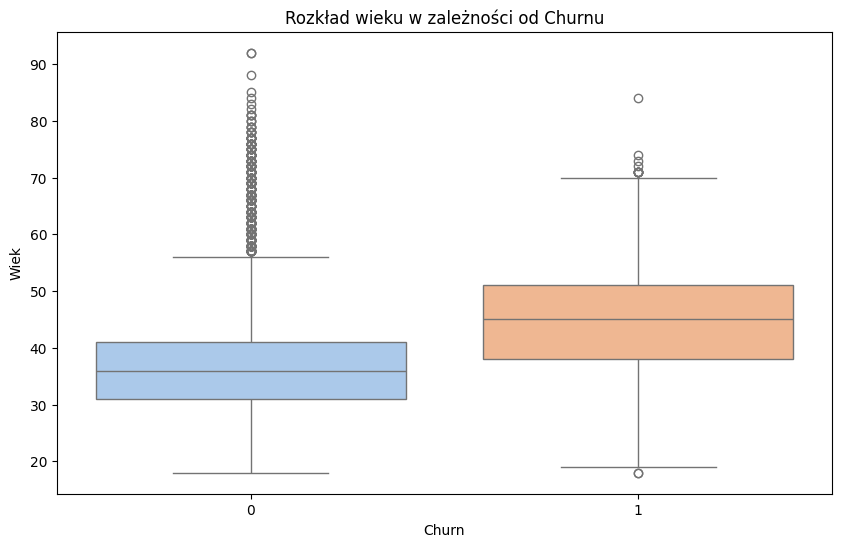

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn', y='age', data=df_spark.toPandas(), palette='pastel')
plt.title('Rozkład wieku w zależności od Churnu')
plt.xlabel('Churn')
plt.ylabel('Wiek')
plt.show()


### **Identyfikacja wartości odstających**

In [23]:
def find_outliers(df, churn_value):
    # Obliczenie granic wąsów dla danej grupy
    group_stats = df.filter(df['churn'] == churn_value).selectExpr('percentile(age, array(0.25, 0.75)) as quartiles').collect()[0]
    Q1, Q3 = group_stats['quartiles'][0], group_stats['quartiles'][1]
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    # Filtrowanie danych i identyfikacja wartości odstających
    outliers = df.filter((df['churn'] == churn_value) & ((df['age'] < lower_fence) | (df['age'] > upper_fence)))

    # Wyświetlenie liczby wartości odstających
    num_outliers = outliers.count()
    print(f"Liczba wartości odstających w grupie {churn_value}: {num_outliers}")

# Identyfikacja wartości odstających dla grupy '0'
find_outliers(df_spark, 0)

# Identyfikacja wartości odstających dla grupy '1'
find_outliers(df_spark, 1)


Liczba wartości odstających w grupie 0: 486
Liczba wartości odstających w grupie 1: 13


Grupa '0' (Churn = 0):
Mediana wieku wynosi 36 lat, co oznacza, że połowa klientów w tej grupie ma mniej niż 36 lat.Dolna granica wąsów (lower fence) wynosi 18 lat, co oznacza brak wartości odstających poniżej tej granicy. Jednakże, górna granica wąsów (upper fence) wynosi 56 lat, co oznacza, że istnieje duża liczba wartości odstających powyżej tej granicy, aż do maksymalnej wartości 92 lat.

Grupa '1' (Churn = 1):
Mediana wynosi 45 lata, co oznacza, że połowa klientów, którzy odeszli, miała mniej niż 45 lata.
Górna granica wąsów (upper fence) wynosi 70 lat, a maksymalny wiek to 84 lata. Istnieje niewielka liczba wartości odstających powyżej tej granicy.Istnieją wartości poniżej dolnej granicy wąsów, w tym kilka wartości 18 lat, które są uznawane za wartości odstające.

## **Indeksowanie kolumn kategorialnych oraz kodowanie One-Hot**

In [24]:
indexer_country = StringIndexer(inputCol="country", outputCol="country_index")
indexer_gender = StringIndexer(inputCol="gender", outputCol="gender_index")

df_spark = indexer_country.fit(df_spark).transform(df_spark)
df_spark = indexer_gender.fit(df_spark).transform(df_spark)

# Kodowanie One-Hot
encoder_country = OneHotEncoder(inputCols=["country_index"], outputCols=["country_vec"])
encoder_gender = OneHotEncoder(inputCols=["gender_index"], outputCols=["gender_vec"])

df_spark = encoder_country.fit(df_spark).transform(df_spark)
df_spark = encoder_gender.fit(df_spark).transform(df_spark)



In [25]:
df_spark.show()

+------------+-------+------+---+------+---------+---------------+-----------+-------------+----------------+-----+-------------+------------+-------------+-------------+
|credit_score|country|gender|age|tenure|  balance|products_number|credit_card|active_member|estimated_salary|churn|country_index|gender_index|  country_vec|   gender_vec|
+------------+-------+------+---+------+---------+---------------+-----------+-------------+----------------+-----+-------------+------------+-------------+-------------+
|         619| France|Female| 42|     2|      0.0|              1|          1|            1|       101348.88|    1|          0.0|         1.0|(2,[0],[1.0])|    (1,[],[])|
|         608|  Spain|Female| 41|     1| 83807.86|              1|          0|            1|       112542.58|    0|          2.0|         1.0|    (2,[],[])|    (1,[],[])|
|         502| France|Female| 42|     8| 159660.8|              3|          1|            0|       113931.57|    1|          0.0|         1.0|(2,

# **Regresja logistyczna**

In [26]:
selected_cols = ["credit_score", "age", "tenure", "balance", "products_number", "estimated_salary", "credit_card", "active_member", "country_vec", "gender_vec", "churn"]

assembler = VectorAssembler(inputCols=selected_cols[:-5], outputCol="selected_features")
df_transformed = assembler.transform(df_spark)


### **Skalowanie danych**

---



In [27]:
scaler = StandardScaler(inputCol="selected_features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_transformed)
df_scaled = scaler_model.transform(df_transformed)

# Oznaczenie kolumny churn jako target
df_target = df_scaled.withColumn("target", col("churn"))

df_selected = df_target.select("scaled_features", "credit_card", "active_member", "country_vec", "gender_vec", "target")

assembler = VectorAssembler(inputCols=["scaled_features", "credit_card", "active_member", "country_vec", "gender_vec"], outputCol="features")
df_features = assembler.transform(df_selected)

### **Podzielenie danych na zbiór treningowy i testowy**

In [28]:
scaled_train_data, scaled_test_data = df_features.randomSplit([0.8, 0.2], seed=42)

print("Liczba wierszy w zbiorze treningowym:", scaled_train_data.count())
print("Liczba wierszy w zbiorze testowym:", scaled_test_data.count())


Liczba wierszy w zbiorze treningowym: 8079
Liczba wierszy w zbiorze testowym: 1921


### **Inicjalizacja modelu regresji logistycznej**

In [29]:
logistic_regression = LogisticRegression(featuresCol="scaled_features", labelCol="target")

### **Dopasowanie modelu do danych treningowych**

In [30]:
logistic_regression_model = logistic_regression.fit(scaled_train_data)

### **Prognozowanie na danych testowych**

In [31]:
logistic_regression_predictions = logistic_regression_model.transform(scaled_test_data)

### **Ocena modelu**

In [32]:
evaluator_accuracy_l = MulticlassClassificationEvaluator(labelCol="target", metricName="accuracy")
accuracy = evaluator_accuracy_l.evaluate(logistic_regression_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7912545549193128


Model osiągnął dokładność na poziomie 79,12%, co oznacza, że poprawnie sklasyfikował 79,12% wszystkich przypadków.



In [33]:
evaluator_precision_l = MulticlassClassificationEvaluator(labelCol="target", metricName="weightedPrecision")
precision = evaluator_precision_l.evaluate(logistic_regression_predictions)
print(f"Precision: {precision}")


Precision: 0.7113346482642318


Precyzja wynosi 71,1%, co oznacza, że 71,1% przypadków sklasyfikowanych jako "churn" (odejście klienta) było poprawnych. Wartość ta jest istotna, gdy zależy nam na minimalizacji błędów w identyfikacji odchodzących klientów.

In [34]:
prediction_and_label_l = logistic_regression_predictions.select("prediction", "target").rdd.map(lambda x: (float(x["prediction"]), float(x["target"])))
metrics = MulticlassMetrics(prediction_and_label_l)
confusion_matrix = metrics.confusionMatrix().toArray()
print(f"Confusion Matrix:\n{confusion_matrix}")

Confusion Matrix:
[[1498.   58.]
 [ 343.   22.]]


Model jest skuteczny w identyfikowaniu klientów, którzy nie odejdą (TN: 1498), co jest pozytywnym wynikiem.
Istnieje jednak ryzyko, że model przewidzi odejście klienta, gdy tak naprawdę nie odejdzie (FP:58 ).
Dodatkowo, model ma trudności w identyfikacji klientów, którzy faktycznie odejdą (TP: 22), co jest widoczne w wyższej liczbie False Negative (FN: 343).


# **Drzewo decyzyjne**

In [35]:
feature_cols = ["credit_score", "age", "tenure", "balance", "products_number", "credit_card", "active_member", "estimated_salary", "country_vec", "gender_vec"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
transformed_df = assembler.transform(df_spark)

# Oznaczenie kolumny churn jako target
transformed_df = transformed_df.withColumn("target", col("churn"))

transformed_df.select("features", "target").show()


+--------------------+------+
|            features|target|
+--------------------+------+
|[619.0,42.0,2.0,0...|     1|
|[608.0,41.0,1.0,8...|     0|
|[502.0,42.0,8.0,1...|     1|
|(11,[0,1,2,4,7,8]...|     0|
|[850.0,43.0,2.0,1...|     0|
|[645.0,44.0,8.0,1...|     1|
|[822.0,50.0,7.0,0...|     0|
|[376.0,29.0,4.0,1...|     1|
|[501.0,44.0,4.0,1...|     0|
|[684.0,27.0,2.0,1...|     0|
|[528.0,31.0,6.0,1...|     0|
|[497.0,24.0,3.0,0...|     0|
|[476.0,34.0,10.0,...|     0|
|(11,[0,1,2,4,7,8]...|     0|
|[635.0,35.0,7.0,0...|     0|
|[616.0,45.0,3.0,1...|     0|
|[653.0,58.0,1.0,1...|     1|
|[549.0,24.0,9.0,0...|     0|
|(11,[0,1,2,4,7,10...|     0|
|[726.0,24.0,6.0,0...|     0|
+--------------------+------+
only showing top 20 rows



### **Inicjalizacja modelu drzewa decyzyjnego**

In [36]:
tree_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="target", maxDepth=1, seed=101, minInstancesPerNode=2)

### **Podział na zbiór treningowy i testowy**

In [37]:
train_data, test_data = transformed_df.randomSplit([0.8, 0.2], seed=42)

print("Liczba wierszy w zbiorze treningowym:", train_data.count())
print("Liczba wierszy w zbiorze testowym:", test_data.count())

Liczba wierszy w zbiorze treningowym: 8079
Liczba wierszy w zbiorze testowym: 1921


### **Dopasowanie modelu do danych treningowych**





In [38]:
tree_model = tree_classifier.fit(train_data)

### **Prognozowanie na danych testowych**

In [39]:
tree_model_predictions = tree_model.transform(test_data)

### **Ocena modelu**

In [40]:
evaluator_precision_d = MulticlassClassificationEvaluator(labelCol="target", metricName="accuracy")
accuracy = evaluator_precision_d.evaluate(tree_model_predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.7886517438833941


 Model osiągnął dokładność na poziomie około 78.87%, co oznacza, że około 78.87% przypadków w zbiorze testowym zostało poprawnie sklasyfikowanych.

In [41]:
evaluator_precision_d = MulticlassClassificationEvaluator(labelCol="target", metricName="weightedPrecision")
precision = evaluator_precision_d.evaluate(tree_model_predictions)
print(f"Precision: {precision}")

Precision: 0.6219715731303186


Precyzja wynosi około 62.2%, co oznacza, że spośród przypadków, które model sklasyfikował jako pozytywne, tylko około 62.2% to rzeczywiście prawdziwie pozytywne przypadki.

In [42]:
prediction_and_label_d = tree_model_predictions.select("prediction", "target").rdd.map(lambda x: (float(x["prediction"]), float(x["target"])))
metrics = MulticlassMetrics(prediction_and_label_d)
confusion_matrix = metrics.confusionMatrix().toArray()
print(f"Confusion Matrix:\n{confusion_matrix}")

Confusion Matrix:
[[1515.    0.]
 [ 406.    0.]]


Model drzewa decyzyjnego uzyskał następujące wyniki w macierzy pomyłek: 1515 poprawnych przewidywań braku odejścia klientów (True Negatives), 0 przypadków błędnych przewidywań braku odejścia (False Positives), 0 przypadków poprawnych przewidywań odejścia (True Positives) oraz 406 przypadki błędnych przewidywań odejścia (False Negatives). Wynik ten sugeruje, że model może mieć trudności w identyfikacji klientów, którzy faktycznie odejdą, co wymaga dalszej analizy i dostosowywania parametrów modelu.

### **Optymalizacja Hiperparametrów dla Modelu Drzewa Decyzyjnego**

In [43]:
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="target")

pipeline = Pipeline(stages=[dt_classifier])

param_grid = ParamGridBuilder().addGrid(dt_classifier.maxDepth, [1, 2, 3, 4, 5, 7, 10, 12]) \
                                .addGrid(dt_classifier.minInstancesPerNode, [1, 2, 3, 4, 5, 6, 8, 10]) \
                                .build()

cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy"),
                                 numFolds=5)


### **Dopasowanie modelu za pomocą kroswalidacji na danych treningowych**

In [44]:
cv_model = cross_validator.fit(train_data)

### **Prognozowanie na danych testowych**

In [45]:
predictions = cv_model.transform(test_data)

### **Ocena dokładności modelu na danych testowych**

In [46]:
accuracy = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy").evaluate(predictions)
print("Accuracy:", accuracy)


Accuracy: 0.8459135866736075


In [47]:
correct_predictions = predictions.filter(col("target") == col("prediction")).count()
total_predictions = predictions.count()
precision = correct_predictions / total_predictions
print("Precision:", precision)

Precision: 0.8459135866736075


In [48]:
prediction_and_label = predictions.select("prediction", "target").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(prediction_and_label)
confusion_matrix = metrics.confusionMatrix()
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
DenseMatrix([[1449.,   66.],
             [ 230.,  176.]])


In [49]:
best_model = cv_model.bestModel

best_max_depth = best_model.stages[0].getOrDefault("maxDepth")
best_min_instances_per_node = best_model.stages[0].getOrDefault("minInstancesPerNode")

print(f"Best Max Depth: {best_max_depth}")
print(f"Best Min Instances Per Node: {best_min_instances_per_node}")

Best Max Depth: 7
Best Min Instances Per Node: 6



Otrzymano model drzewa decyzyjnego, którego skuteczność (accuracy) wynosi około 84,6%. Precyzja (precision) modelu, czyli stosunek prawdziwie pozytywnych przewidywań do wszystkich pozytywnych przewidywań, także wynosi około 84,6%.

Macierz pomyłek (confusion matrix) przedstawia rozkład wyników klasyfikacji:

1449 prawdziwie negatywne przypadki (TN),

66 fałszywie pozytywne przypadki (FP),

230 fałszywie negatywne przypadki (FN),

176 prawdziwie pozytywne przypadki (TP).

Rekomendowane hiperparametry dla tego modelu to głębokość drzewa równa 7 oraz minimalna liczba instancji w węźle równa 6.

# **Porównanie algorytmów**




Dokładność: Drzewo decyzyjne osiągnęło wyższą dokładność (84.6%) w porównaniu do regresji logistycznej (79.12%).

Precyzja: Drzewo decyzyjne ponownie osiągnęło wyższą precyzję (84.6% dla drzewa decyzyjnego, 71.1% dla regresji logistycznej).

Macierz Pomyłek: Drzewo decyzyjne wydaje się lepiej radzić sobie z identyfikacją przypadków odejścia klienta, co widoczne jest w niższej liczbie False Negative.

Podsumowując, drzewo decyzyjne wydaje się być bardziej skutecznym modelem w identyfikacji przypadków odejścia klienta, uzyskując wyższą dokładność i lepszą precyzję w porównaniu do regresji logistycznej.